# Author Connections and probabilities

In [2]:
from __future__ import division
from __future__ import print_function
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
import os
os.getcwd()
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import csv
from collections import Counter
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")


import random
from PIL import Image
from os import path
from nltk.corpus import stopwords
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

import mysql.connector
from mysql.connector import errorcode
from mysql.connector import Error

import plotly
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='raunakm90', api_key='qh9wd16d6g')

import plot_network
import plotly.plotly as py
from plotly.graph_objs import *
#sns.set_context("poster")

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\Users\Raunak Mundada\Anaconda2\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



## Import data from SQL

In [3]:
import mysql_setup
query_list,field_names = mysql_setup.query_with_fetchmany("SELECT * FROM Author")
Author = mysql_setup.make_frame(query_list,field_names)

In [4]:
query_list,field_names = mysql_setup.query_with_fetchmany("SELECT * FROM Publishing_Detail")
Publishing_Detail = mysql_setup.make_frame(query_list,field_names)

## Get top authors and corresponding publications

In [5]:
ind = Author.Author_Cited_By.sort_values(ascending = False).index
# Select top 4 indices
ind = ind[0:4]
top_Authors = Author[Author.index.isin(ind)]
a_dict = top_Authors.set_index('Author_Id')['Author_Name'].to_dict()
a_dict

{u'JicYPdAAAAAJ': u'Geoffrey Hinton',
 u'ZpG_cJwAAAAJ': u'Robert Tibshirani',
 u'vtegaJgAAAAJ': u'vapnik',
 u'yxUduqMAAAAJ': u'Michael I. Jordan'}

In [6]:
#Get the publications of the required authors
a_id = a_dict.keys()
DB_NAME = 'NLP_Project'
in_p=', '.join(list(map(lambda x: '%s', a_id)))
sql = ("SELECT * FROM publishing_Detail WHERE Author_Id in (%s)")
sql = sql % in_p
query_list = list()
cnx = mysql.connector.connect(user='root',password = "raunak")
cursor = cnx.cursor()
cnx.database = DB_NAME
cursor.execute(sql,a_id)

for row in iter(cursor):
        query_list.append(row)
        num_fields = len(cursor.description)
        field_names = [i[0] for i in cursor.description]
        field_names
        
cursor.close()
cnx.close()
Author_Pubs = mysql_setup.make_frame(query_list,field_names)
Author_Pubs.head()

,Pub_Id,Pub_Title,Pub_Authors,Pub_Publisher,Pub_Journal,Pub_Abstract,Pub_Volume,Pub_Year,Pub_Citedby,Pub_URL,Author_Id
0,JicYPdAAAAAJ:-6RzNnnwWf8C,"Pittsburgh, PA 15213","David C Plant,Steven J Now1an,Geoffrey E Hinton",NULL,NULL,"7 Abstract Rumelhart, Hinton and Williams [Rum...",NULL,1986,-99,https://www.cs.toronto.edu/~hinton/absps/bptr.pdf,JicYPdAAAAAJ
1,JicYPdAAAAAJ:-7ulzOJl1JYC,Error Propagation,"DE Rummelhart,GE Hinton,RJ Williams Learning I...",NULL,Parallel Distributed Processing,NULL,NULL,-99,20,http://scholar.google.com/scholar?cluster=1578...,JicYPdAAAAAJ
2,JicYPdAAAAAJ:-DxkuPiZhfEC,WJ CLANCEY,"S AMAREL,Y ANZAI,HG BARROW,H BERLINER,RS BOYER...",NULL,NULL,NULL,NULL,-99,-99,http://scholar.google.com/scholar?cluster=6697...,JicYPdAAAAAJ
3,JicYPdAAAAAJ:-f6ydRqryjwC,Learning translation invariant recognition in ...,Geoffrey E Hinton,Springer Berlin Heidelberg,NULL,One major goal of research on massively parall...,NULL,1987,177,http://link.springer.com/chapter/10.1007/3-540...,JicYPdAAAAAJ
4,JicYPdAAAAAJ:-mN3Mh-tlDkC,"E ‘-Jgjfssl ‘-y Cw. 117-tae.\, I987./ttttttttt...","Geoffrey E Hinton,David C Plaut",NULL,NULL,\ Abstract _ Connectionist models usually have...,NULL,-99,-99,https://www.cnbc.pitt.edu/~plaut/papers/pdf/Hi...,JicYPdAAAAAJ


## Function to handle strings

In [7]:
import string
exclude = set(string.punctuation)

def handle_strings(x):
    """
    Helper function to make string all lower and remove punctuation.
    
    x: any string
    """
    x = x.lower()
    x = ''.join(ch for ch in x if ch not in exclude)
    return x

## How many times have the top authors cited each other?

The table is arranged in the following manner - Row cites the column

In [8]:
adj_mat = pd.DataFrame(0.0, index=a_dict.values(), columns=a_dict.values())
prob = pd.DataFrame(0.0, index=a_dict.values(), columns=a_dict.values())
for key in a_dict.iterkeys():
    x = Author_Pubs[Author_Pubs['Author_Id'] == key]
    n = len(x)
    a = a_dict[key]
    Pub_Authors = x['Pub_Authors'].tolist()
    Pub_Authors = ",".join(unicode(i) for i in Pub_Authors if not i.isdigit())
    Pub_Authors = Pub_Authors.split(",")
    for value in a_dict.itervalues():
        if value!=a:
            #m = [s for s in Pub_Authors if handle_strings(value) in handle_strings(s)]
            m = [s for s in Pub_Authors if fuzz.partial_ratio(handle_strings(value),handle_strings(s))>85]
            adj_mat[a][value] = len(m) + adj_mat[a][value]
            prob[a][value] = len(m)*100/n
print (adj_mat)
print (prob)

Gr=nx.from_numpy_matrix(adj_mat.values)

position=nx.circular_layout(Gr)
labels = list(adj_mat.columns.values)

traceE=plot_network.scatter_edges(Gr, position)
traceN=plot_network.scatter_nodes(Gr,position,labels = labels,size_flag = 1)

fig = Figure(data=Data([traceE, traceN]),
             layout=Layout(
                title='<br>Network Graph - Top Authors',
                titlefont=dict(size=18),
                showlegend=False, 
                width=1000,
                height=500,
                margin=dict(b=20,l=5,r=5,t=40),
                hovermode='closest',
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

#py.iplot(fig, filename='Top Authors')

iplot(fig)

                   Robert Tibshirani  vapnik  Geoffrey Hinton  Michael I. Jordan
Robert Tibshirani                0.0     0.0              9.0                1.0
vapnik                           0.0     0.0              0.0                1.0
Geoffrey Hinton                 10.0     0.0              0.0                5.0
Michael I. Jordan                2.0     2.0              5.0                0.0
                   Robert Tibshirani    vapnik  Geoffrey Hinton  Michael I. Jordan
Robert Tibshirani           0.000000  0.000000         1.764706           0.127389
vapnik                      0.000000  0.000000         0.000000           0.127389
Geoffrey Hinton             1.312336  0.000000         0.000000           0.636943
Michael I. Jordan           0.262467  0.231214         0.980392           0.000000


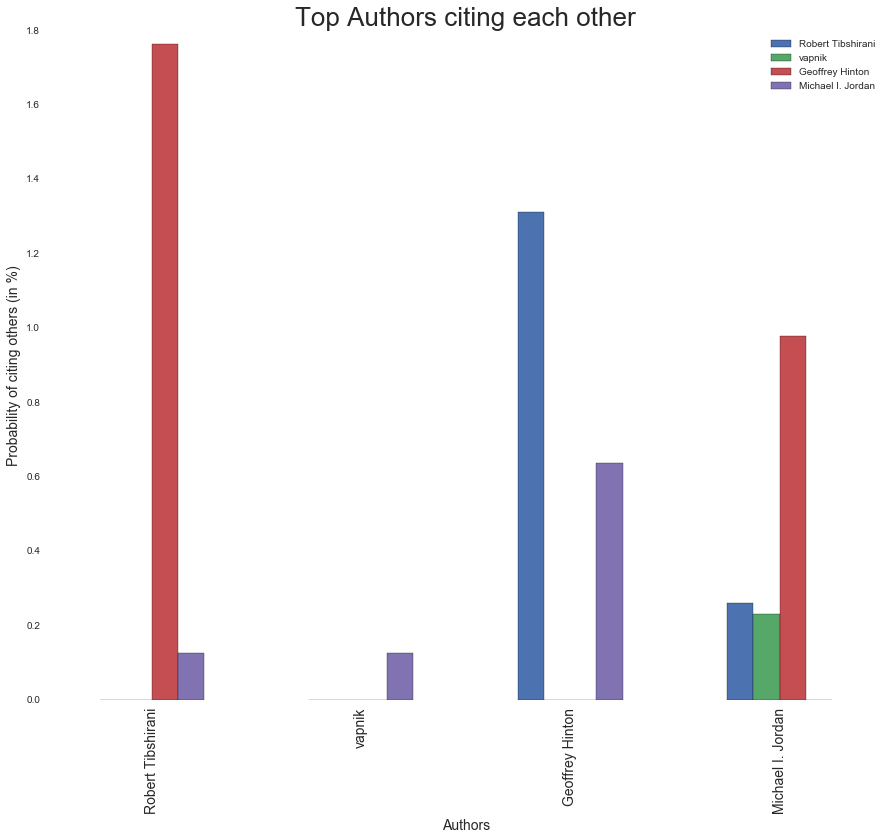

In [9]:
# Create a figure of given size
fig = plt.figure(figsize=(15,12))
# Add a subplot
ax = fig.add_subplot(111)

prob.plot(kind = 'bar',ax=ax,title = "Top Authors citing each other")

# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)
ax.set_title(ax.get_title(),fontsize=26)

ax.set_xlabel("Authors",fontsize = 14)
xticks = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(xticks,fontsize = 14)

ax.set_ylabel("Probability of citing others (in %)",fontsize =14)
#yticks = [item.get_yticklabels() for item in ax.get_yticklabels()]
#ax.yaxis.set_ticks(yticks)
#ax.set_yticklabels(yticks,fontsize = 14)
#yticks = [0,1,2,3,4]
#ax.yaxis.set_ticks(yticks)
#ax.set_yticklabels(yticks, fontsize=16)

## How are the authors in the database connected to each other?

In [10]:
ind = Author.Author_Cited_By.sort_values(ascending = False).index
top_Authors = Author[Author.index.isin(ind)]
a_dict = top_Authors.set_index('Author_Id')['Author_Name'].to_dict()

### Exact Matching of strings

In [11]:
adj_mat = pd.DataFrame(0.0, index=a_dict.values(), columns=a_dict.values())
for key in a_dict.iterkeys():
    x = Publishing_Detail[Publishing_Detail['Author_Id'] == key]
    n = len(x)
    a = a_dict[key]
    Pub_Authors = x['Pub_Authors'].tolist()
    Pub_Authors = ",".join(unicode(i) for i in Pub_Authors if not i.isdigit())
    Pub_Authors = Pub_Authors.split(",")
    fname = open("./List"+a,"wb")
    fname.writelines(Pub_Authors)
    fname.close()

    for value in a_dict.itervalues():
        if value!=a:
            m = [s for s in Pub_Authors if handle_strings(value) in handle_strings(s)]
            adj_mat[a][value] = len(m)/n

pd.DataFrame.to_clipboard(adj_mat)


Gr=nx.from_numpy_matrix(adj_mat.values)
position=nx.circular_layout(Gr)
labels = list(adj_mat.columns.values)

traceE=plot_network.scatter_edges(Gr, position)
traceN=plot_network.scatter_nodes(Gr,position,labels = labels,size_flag = 1)

fig = Figure(data=Data([traceE, traceN]),
             layout=Layout(
                title='<br>Network Graph - Author Connections',
                titlefont=dict(size=18),
                showlegend=False, 
                width=750,
                height=750,
                margin=dict(b=20,l=5,r=5,t=40),
                hovermode='closest',
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

#py.iplot(fig, filename='Top Authors')

iplot(fig)

### Visualize the connection strength

In [12]:
annotations = []
row_labels = adj_mat.columns
col_labels = adj_mat.columns
for n, row in enumerate(adj_mat.values):
    for m, val in enumerate(row):
        val = adj_mat.values[n][m].round(2)
        annotations.append(
            dict(
                text=str(val),
                x=row_labels[m], y=col_labels[n],
                xref='Authors', yref='Authors',
                font=dict(color='white' if val > 20 else 'black'),
                showarrow=False)
            )

colorscale = [[0, '#3D9970'], [1, '#001f3f']]  # custom colorscale
trace = Heatmap(x=row_labels, y=col_labels, z=adj_mat.values.round(2), colorscale = colorscale,showscale=False)

fig = Figure(data=[trace])
fig['layout'].update(
    title="Connection Strength",
    annotations=annotations,
    xaxis=dict(ticks=''),
    # ticksuffix is a workaround to add a bit of padding
    yaxis=dict(ticks='', ticksuffix='  '),
    width=1000,
    height=1000,
    autosize=False
)
py.iplot(fig, filename='Connection Strength', height=1000)

### Fuzzy Matching of strings (cut-off ratio set at 90)

In [18]:
# Fuzzy partial matching of names

adj_mat = pd.DataFrame(0.0, index=a_dict.values(), columns=a_dict.values())
for key in a_dict.iterkeys():
    x = Publishing_Detail[Publishing_Detail['Author_Id'] == key]
    n = len(x)
    a = a_dict[key]
    Pub_Authors = x['Pub_Authors'].tolist()
    Pub_Authors = ",".join(unicode(i) for i in Pub_Authors if not i.isdigit())
    
    Pub_Authors = Pub_Authors.split(",")
    fname = open("./List"+a,"wb")
    fname.writelines(Pub_Authors)
    fname.close()
    for value in a_dict.itervalues():
        if value!=a:
            m = [s for s in Pub_Authors if fuzz.partial_ratio(handle_strings(value),handle_strings(s))>90]
            adj_mat[a][value] = len(m)/n

Gr=nx.from_numpy_matrix(adj_mat.values)
position=nx.circular_layout(Gr)
labels = list(adj_mat.columns.values)

traceE=plot_network.scatter_edges(Gr, position)
traceN=plot_network.scatter_nodes(Gr,position,labels = labels,size_flag = 1)

fig = Figure(data=Data([traceE, traceN]),
             layout=Layout(
                title='<br>Network Graph - Author Connections (Fuzzy Matching)',
                titlefont=dict(size=18),
                showlegend=False, 
                width=1000,
                height=1000,
                margin=dict(b=20,l=5,r=5,t=40),
                hovermode='closest',
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

#py.iplot(fig, filename='Top Authors')

iplot(fig)

### Visualize the adjacency matrix

In [19]:
annotations = []
row_labels = adj_mat.columns
col_labels = adj_mat.columns
for n, row in enumerate(adj_mat.values):
    for m, val in enumerate(row):
        val = adj_mat.values[n][m].round(2)
        annotations.append(
            dict(
                text=str(val),
                x=row_labels[m], y=col_labels[n],
                xref='Authors', yref='Authors',
                font=dict(color='white' if val > 20 else 'black'),
                showarrow=False)
            )

colorscale = [[0, '#3D9970'], [1, '#001f3f']]  # custom colorscale
trace = Heatmap(x=row_labels, y=col_labels, z=adj_mat.values.round(2), colorscale = colorscale,showscale=False)

fig = Figure(data=[trace])
fig['layout'].update(
    title="Connection Strength",
    annotations=annotations,
    xaxis=dict(ticks=''),
    # ticksuffix is a workaround to add a bit of padding
    yaxis=dict(ticks='', ticksuffix='  '),
    width=1000,
    height=1000,
    autosize=False
)
py.iplot(fig, filename='Connection Strength', height=1000)